# Homework 2

DUE Oct 27th at 11:59 PM

## Problem 1

In this problem, we will vary the capacity of our estimator a.k.a machine learning model and see the effect on performance. We are interested in understanding the bias-variance tradeoff and how model capacity influences training and test error.

Run the following code to load the Boston housing dataset. We will be regressing the median price of a house in Boston using 13 features of its residential locality. This dataset was collected by the U.S. Census Service in the 1970s.

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import numpy as np

X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, random_state=123,
                                                    shuffle=True)

a) Fill in the code template below to uniformly draw samples with replacement from the training data. The size of the sampled dataset should be equal to the training dataset size. 

In [2]:
def draw_sample(X,y):
    indx = np.random.choice(len(X), len(X), replace = True)
    x_samp = X[indx]
    y_samp = y[indx]
    return x_samp, y_samp

b) We will be using Decision Trees for this problem. Note that the capacity of a decision tree is its maximum depth/number of nodes. In this part, for each depth parameter, you have to run multiple trials. In each trial, you sample a dataset from the training set using the code in part a. Use the sampled dataset to train a decision tree model and obtain predictions on the test data (cross-val is not required). Average predictions over the trials to get the mean estimator for each depth. 

In [3]:
from sklearn.tree import DecisionTreeRegressor
np.random.seed(89)
depths = np.arange(2,11)
num_trials = np.arange(100)
means = []
variances =[]
avg_train_err = []
avg_test_err = []
for depth in depths:
    # need to store the test predictions and the train values to calculate part d
    predictions =[]
    train_scores = []
    y_train_vals = []
    y_test_vals = []
    
    # initialize the Decision Tree Regressor
    tree = DecisionTreeRegressor(max_depth = depth)
    
    # iterate through the trials
    for trial in num_trials:
        
        # draw a new sample from the training data
        new_train = draw_sample(X_train, y_train)
        x_use = new_train[0]
        y_use = new_train[1]
        
        # fit the tree model to the new training data
        tree.fit(x_use,y_use)
        
        # keep the test predictions
        predictions.append(tree.predict(X_test))
        
        # keep the train predictions
        train_scores.append(tree.predict(x_use))
        
        # also need to keep the true y_use and y_test
        y_train_vals.append(y_use)
        y_test_vals.append(y_test)
    
    # create a matrix that stores all the predictions
    prediction_matrix = np.array(predictions)
    
    # store the mean and variances to use in later parts
    mean_predicts = np.mean(prediction_matrix, axis = 0)
    vars_of_predictions = np.var(prediction_matrix, axis = 0)
    means.append(mean_predicts)
    variances.append(vars_of_predictions)
    
    # change the data type to array so much easier to work with
    train_matrix = np.array(train_scores)
    ytrain_matrix = np.array(y_train_vals)
    ytest_matrix = np.array(y_test_vals)
    
    # store the train and test error
    avg_train_err.append(np.mean(np.absolute(train_matrix - ytrain_matrix)))
    avg_test_err.append(np.mean(np.absolute(prediction_matrix - y_test)))


c) Compute the average bias<sup>2,</sup> and average variance and plot them as a function of depth on the same plot. What does the general trend indicate?

In [4]:
# calculate the bias squared for each depth
bias_sq = []
for i in range(9):
    use_bias = np.square(means[i]-y_test).mean()
    bias_sq.append(use_bias)

# calculate the average variance for each depth
variance = []
for i in range(9):
    use_var = np.mean(variances[i])
    variance.append(use_var)

In [5]:
bv_df = pd.DataFrame({'Depth':depths,'Bias Squared': bias_sq,'Variance':variance})
bv_df

,Depth,Bias Squared,Variance
0,2,29.148532,7.457474
1,3,20.079597,13.341545
2,4,16.959014,13.863307
3,5,16.062527,15.649275
4,6,15.987568,16.907620
5,7,14.901114,18.141800
6,8,13.752170,16.752413
7,9,15.900485,18.394839
8,10,15.786618,18.634643


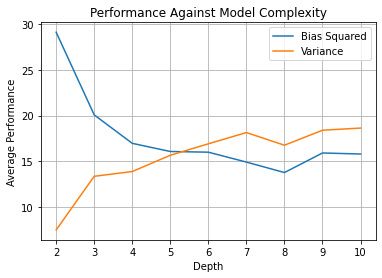

In [7]:
import matplotlib.pyplot as plt

plt.plot(depths,bias_sq, label = 'Bias Squared')
plt.plot(depths,variance, label = 'Variance')
plt.xlabel('Depth')
plt.ylabel('Average Performance')
plt.title('Performance Against Model Complexity')
plt.legend()
plt.grid()
print()

# COMMENT
_The general trend indicates that as the model complexity increases, so does the variance. The opposite is true for the Bias Squared which shows a gradual decrease in average performance as the depth increases. This is because as the depth increases, the more flexible and overfitting the model is. However, with a shorter depth, the model is too smooth and cannot generalize to new data. I expect that the bias will continue to decrease and the variance will continue to increase as depth gets bigger. We regard the optimal depth to be where the Bias and Variance is minimized or intersecting which is between 5 and 6._

d) Compute the average training and average test error and plot them as a function of the depth.  What do the general trends from both the plots indicate?

In [8]:
train_test_df = pd.DataFrame({'Depth':depths,'Training Error': avg_train_err,'Testing Error':avg_test_err})
train_test_df

,Depth,Training Error,Testing Error
0,2,3.383536,4.177737
1,3,2.616248,3.770556
2,4,2.021982,3.419914
3,5,1.585315,3.384659
4,6,1.180106,3.392840
5,7,0.849342,3.449965
6,8,0.568423,3.427517
7,9,0.355610,3.553423
8,10,0.226538,3.569865


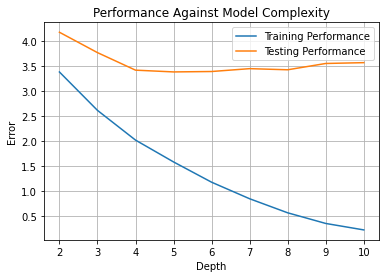

In [9]:
plt.plot(depths,avg_train_err, label = 'Training Performance')
plt.plot(depths,avg_test_err, label = 'Testing Performance')
plt.xlabel('Depth')
plt.ylabel('Error')
plt.title('Performance Against Model Complexity')
plt.legend()
plt.grid()
print()

# COMMENT
_The general trend indicates that the training error decreases as the depth increases. However, the testing error stays pretty stagnant and doesn't really show much improvement even as depth increases. This is expected since the model is trained on the training data but when it is exposed to unseen data, it does not work well. This large gap between training and testing performance indicates that the model would not work well with new data since it does not generalize easily._

## Problem 2

In this problem, we will apply and compare 2 methods for dimensionality reduction: **PCA** and **LDA**. Dimensionality reduction is an essential step in preparing your data before passing them into a learning model. If done correctly, the small resulting set of dimensions can capture most of the important patterns in the data while reducing noises and training time. However, too much compression can lead to loss of useful information.

Run the following code to load the Boston dataset as a binary classification problem.

In [10]:
np.random.seed(937)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)

median = np.median(y)
for i in range(len(y)):
    if y[i] > median:
        y[i] = 1
    else:
        y[i] = 0

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    shuffle=True)

a) Use PCA to reduce the training data to one dimensions. Fit a SVM classifier on the reduced data.

In [11]:
np.random.seed(99)
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# pca to one dimension
pca_estimator = PCA(n_components = 1)

# fit the model on the training data
reduced_xtrain = pca_estimator.fit_transform(X_train)

# initialize and fit svm to the reduced data
class1 = SVC(gamma = 'auto')
class1.fit(reduced_xtrain,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now evaluate the trained model on the testing data. Remember to transform the testing data using the same PCA model fitted on your training data. Report the result as a confusion matrix.

In [12]:
np.random.seed(38)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# transform the testing data using the same PCA model
reduced_xtest = pca_estimator.transform(X_test)

# Predict results from pca model
y_pred = class1.predict(reduced_xtest)

# print performance of the svm on test data
confusion_matrix(y_test, y_pred)

array([[34, 13],
       [16, 39]])

b) Use LDA to reduce the training data to two dimensions. Fit a SVM classifier on the reduced data.

In [13]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(34)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

# initialize LDA model
LDA_estimator = LinearDiscriminantAnalysis(n_components = 2)

# fit the model on the training data
reduced_xtrain = LDA_estimator.fit_transform(X_train, y_train)

# initialize and fit svm to the reduced data
class2 = SVC(gamma = 'auto')
class2.fit(reduced_xtrain,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Similar to part **b**, evaluate the trained model on the testing data. Report the result as a confusion matrix

In [14]:
np.random.seed(28)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# transform the testing data using the same PCA model
reduced_xtest = LDA_estimator.transform(X_test)

# Predict results from lda model
y_pred = class2.predict(reduced_xtest)

# print performance of the svm on test data
confusion_matrix(y_test, y_pred)

array([[40,  7],
       [19, 36]])

c) Now without any dimensionality reduction, train a SVM model on the original data. Report the result as a confusion matrix.

In [15]:
np.random.seed(94)
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# initialize and fit svm to original data
class3 = SVC(gamma = 'auto')
class3.fit(X_train,y_train)

# predict results from SVM model of original data
y_pred = class3.predict(X_test)

# print performance of the svm on test data
confusion_matrix(y_test, y_pred)

array([[21, 26],
       [ 4, 51]])

d) Compare the confusion matrices from the three strategies. 

# COMMENT
_The best performance I got was with LDA dimensionality reduction where there were only 26 missclassifications. This is a smaller error compared to the PCA reduced data with 29 missclassifications and the worst performing model which was the unreduced model with 30 missclassifications. Looking at specifically the false classifications, the unreduced model has significantly more false positives that false negatives. The two other strategies showed more false positive classifications, but not by a lot like we see with the unreduced model. As for the correctly predicted values, Both LDA and the unreduced models correctly predicted more positives than negatives while the PCA reduced model correctly predicted more negatives than positives._

## Problem 3

In this problem, you will investigate how the size of the training data on the performance of a generative model (NB) and a discriminative model (LR). **You are free to use scikit-learn's NB and LR.** 




Run the following code to load and prepare the Boston dataset.

In [16]:
np.random.seed(945)
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)

median = np.median(y)
for i in range(len(y)):
    if y[i] > median:
        y[i] = 1
    else:
        y[i] = 0

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    shuffle=True)

a) We will train NB classifiers that use only a portion of the training data. Let's vary this portion from 1% to 100% of the training set (100 iterations). For each portion value, sample the training set according to the portion, train a NB classifer on this portion of the training set, and evaluate the model accuracy on the testing set. Notice that because the quality of the model depends on the specific subset of the training data that we draw, you will have to repeat the experiment many times for any portion value and report the average (If you repeat for a large number of times, say 100, expect your code to run for a few minutes). 

In [17]:
np.random.seed(101)
from sklearn.naive_bayes import MultinomialNB

# save a list of the performance values
perf_vals_NB = []

# iterate through all the portions of the training set
for percent in np.arange(0.01,1.01,0.01):
    perf_each_trial = []
    # obtain the number of values that fit the portion of training we're trying to get
    portion = int(round(len(X_train)*percent))
    
    # repeat the sampling for each portion multiple times to get an average
    for i in range(100):
        # randomly chose the correct portion of indicies to slice from the training sample
        inds = np.random.choice(range(len(X_train)),portion,replace = False)
    
        # create the new samples of correct portion size
        new_X = X_train[inds]
        new_Y = y_train[inds]
    
        # initialize the Naive Bayes Classifier
        gnb = MultinomialNB()
    
        # fit the Classifier to the portion of training and predict y from test
        gnb.fit(new_X, new_Y)
    
        # obtain the score
        curr_score = gnb.score(X_test, y_test)
        perf_each_trial.append(curr_score)
    perf_vals_NB.append(np.mean(perf_each_trial))

Plot the accuracies of the models versus the portion of the training set used. Comment on the effect of increasing the size of the training dataset on the performance of NB.

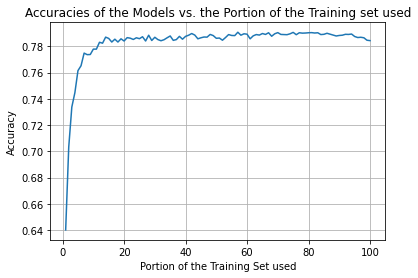

In [18]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,101),perf_vals_NB)
plt.xlabel('Portion of the Training Set used')
plt.ylabel('Accuracy')
plt.title('Accuracies of the Models vs. the Portion of the Training set used')
plt.grid()
print()

# COMMENT
_When we increase the portion of the training set used, or in a general case the size of the training set, the overall performance increases. It looks like after 10% of the training data is being used, the accuracy performance jumps more than 10%. After about 20% of the training set is being used, the accuracy performance stays stagnant at a value around 0.79._

b) Repeat part **b** with LR.

In [19]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

# save a list of the performance values
perf_vals_LR = []

# iterate through all the portions of the training set
for percent in np.arange(0.01,1.01,0.01):
    perf_each_portion = []
    # obtain the number of values that fit the portion of training we're trying to get
    portion = int(round(len(X_train)*percent))
    
    # repeat the sampling for each portion multiple times to get an average
    for i in range(100):
        # randomly chose the correct portion of indicies to slice from the training sample
        inds = np.random.choice(range(len(X_train)),portion,replace = False)
    
        # create the new samples of correct portion size
        new_X = X_train[inds]
        new_Y = y_train[inds]

        # initialize a while loop to check the number of classes in the y train
        if len(np.unique(new_Y)) == 2:
            # initialize the Logistic Regression Classifier
            gnb = LogisticRegression(solver = 'liblinear', max_iter = 100)
    
            # fit the Classifier to the portion of training and predict y from test
            gnb.fit(new_X, new_Y)
    
            # obtain the score
            curr_score = gnb.score(X_test, y_test)
            perf_each_portion.append(curr_score)
    perf_vals_LR.append(np.mean(perf_each_portion))

c) Plot both the results of NB and LR on the same figure.

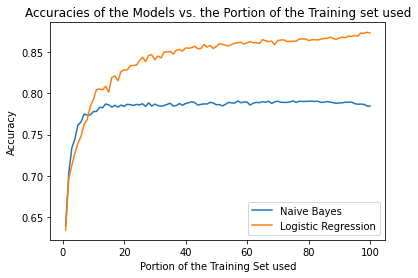

In [20]:
plt.plot(np.arange(1,101),perf_vals_NB, label = 'Naive Bayes')
plt.plot(np.arange(1,101),perf_vals_LR, label = 'Logistic Regression')
plt.xlabel('Portion of the Training Set used')
plt.ylabel('Accuracy')
plt.title('Accuracies of the Models vs. the Portion of the Training set used')
plt.legend()
print()

Between a generative model (NB) and a discriminative model (LR), which is more affected by small training dataset? Which one converges faster? Which one performs better in the long run given enough training data?

# COMMENT
_Towards the leftmost region of the plot (where the portion of the training set is the smallest), the performance for the discriminative model is lower than the generative model. This means that **Logistic Regression is more affected by a smaller training set**. When the training sample size increases, the Logistic Regression performance looks like it is continuously increasing and ends on this plot at 0.88. Meanwhile, the Naive Bayes performance plateaus at around 10% with a performance value of 0.78 until all the training set is used. Based on this information, I believe the **Naive Bayes model converges faster** and the **Logistic Regression model performs better in the long run**._

## Problem 4

In this problem, you will work on the clustering problem using Bottom-up Agglomerative clustering and K-mean clustering.

a) A 4-D dataset is given in **'iris.csv'** with the last column being the ground truth label. Load the file. Store the data in a variable ***X*** and store the label in a variable ***y***. Because clustering is an unsupervised task, there is no need for the labels during training.

In [21]:
iris = pd.read_csv('iris.csv', header = None)
iris.columns = ['Feature 1', 'Feature 2','Feature 3','Feature 4','Label']
# helps for later when we want to use the number for cateogrizing on plots
iris['Label'] = pd.Categorical(iris.Label)
iris['LabelCode'] = iris.Label.cat.codes
x = iris.iloc[:,:4]
y = iris.iloc[:,4]
ycode = iris.iloc[:,5]

b) Train a clustering model using Bottom-up Agglomerative clustering.

In [22]:
np.random.seed(73)
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters = 3)
y_predict = cluster.fit_predict(x)

Visualize your clusters on a 2-D plot. Choose any 2 dimensions from the 4 dimensions to plot. Try to pick the 2 dimensions that best separate the data. Your plot should contains all the data points with points from the same predicted cluster haveing the same color. 

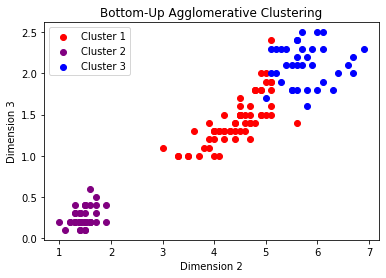

In [23]:
new_tab = pd.DataFrame(data = {'feat_1':x.iloc[:,2],'feat_2':x.iloc[:,3],'class':y_predict})
class1 = new_tab[new_tab['class'] == 0]
class2 = new_tab[new_tab['class'] == 1]
class3 = new_tab[new_tab['class'] == 2]
plt.scatter(class1.iloc[:,0],class1.iloc[:,1], c='red', label = 'Cluster 1')
plt.scatter(class2.iloc[:,0],class2.iloc[:,1], c='purple', label = 'Cluster 2')
plt.scatter(class3.iloc[:,0],class3.iloc[:,1], c='blue', label = 'Cluster 3')
plt.legend()
plt.title('Bottom-Up Agglomerative Clustering')
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 3')
print()

Repeat the visualization step above using the same 2 dimensions. This time, plot according to the ground truth classes. Comment on the performance of your model.

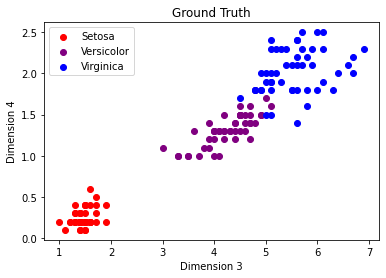

In [24]:
class1 = iris[iris['LabelCode'] == 0]
class2 = iris[iris['LabelCode'] == 1]
class3 = iris[iris['LabelCode'] == 2]
plt.scatter(class1.iloc[:,2],class1.iloc[:,3], c='red', label = 'Setosa')
plt.scatter(class2.iloc[:,2],class2.iloc[:,3], c='purple', label = 'Versicolor')
plt.scatter(class3.iloc[:,2],class3.iloc[:,3], c='blue', label = 'Virginica')
plt.legend()
plt.title('Ground Truth')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 4')
print()

# COMMENT
_The bottom-up clustering algorithm predicted cluster 2 perfectly. Based on comparing it to the ground truth classifications, this cluster represent the Setosa flower. When predicting clusters 1 and 3, it over estimates the boundary between cluster 1 and underestimates the boundary for cluster 3 making them bigger and smaller than their respective true classifications. This clustering algorithm seems to create a boundary that is much more clean than the ground truth since the real classifications do overlap a little bit._

c) Train a clustering model using K-mean clustering.

In [25]:
np.random.seed(46)
from sklearn.cluster import KMeans

cluster2 = KMeans(n_clusters = 3, random_state = 42)
y_means = cluster2.fit_predict(x)

Visualize your clusters on a 2-D plot. Choose any 2 dimensions from the 4 dimensions to plot. Try to pick the 2 dimensions that best separate the data. Your plot should contains all the data points with points from the same predicted cluster haveing the same color.

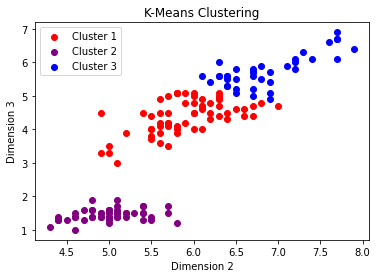

In [26]:
new_tab = pd.DataFrame(data = {'feat_1':x.iloc[:,0],'feat_2':x.iloc[:,2],'class':y_means})
class1 = new_tab[new_tab['class'] == 0]
class2 = new_tab[new_tab['class'] == 1]
class3 = new_tab[new_tab['class'] == 2]
plt.scatter(class1.iloc[:,0],class1.iloc[:,1], c='red', label = 'Cluster 1')
plt.scatter(class2.iloc[:,0],class2.iloc[:,1], c='purple', label = 'Cluster 2')
plt.scatter(class3.iloc[:,0],class3.iloc[:,1], c='blue', label = 'Cluster 3')
plt.legend()
plt.title('K-Means Clustering')
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 3')
print()

Repeat the visualization step above using the same 2 dimensions. This time, plot according to the ground truth classes. Comment on the performance of your model.

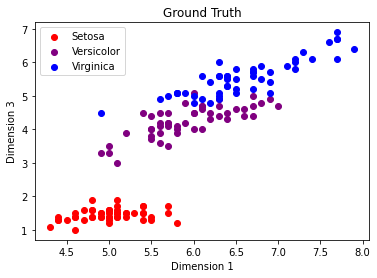

In [27]:
class1 = iris[iris['LabelCode'] == 0]
class2 = iris[iris['LabelCode'] == 1]
class3 = iris[iris['LabelCode'] == 2]
plt.scatter(class1.iloc[:,0],class1.iloc[:,2], c='red', label = 'Setosa')
plt.scatter(class2.iloc[:,0],class2.iloc[:,2], c='purple', label = 'Versicolor')
plt.scatter(class3.iloc[:,0],class3.iloc[:,2], c='blue', label = 'Virginica')
plt.legend()
plt.title('Ground Truth')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
print()

# COMMENT
_Similar to the bottom-up clustering, the k-means clustering algorithm classifued cluster 2 perfectly since it is separate from the other two flower types. This cluster again represents the Setosa flower type. Cluster 1 again over estimates the boundary and custers more of the values that belong to the flower associated with cluster 3. However, based on just looking at the plots, the k-means clustering algorithm has less incorrect classifications than the bottom-up method thus making it better at predicting and establishing these clusters._

## Problem 5

This problem builds on ideas from the paper: “Against prediction: Sentencing, Policing, And Punishing In An Actuarial Age,” Chicago Public Law And Legal Theory Working Paper No. 94, Harcourt, 2005. 

Suppose we have two groups $A$ and $B$ of student population sizes $n$ and $9n$. We find that under equal financial support, group $A$’s dropout rate is $0.2$ dropouts per year per student and that of group $B$ is $0.1$ dropout per person per year. Equal support means that out of a total of $10m$ scholarships, $m$ scholarships are granted to group $A$ and $9m$ scholarships are granted to group $B$. The support is $\frac{m}{n}$ per capita for both groups. So, under equal support, the combined dropout rate over both groups is $0.11n$ per year. 

Suppose we want to bring down the overall dropout rate by increasing the support for group $A$. In order to do that we collected some data and found that we could model the rate of decrease in dropouts for group $A$ by a function as follows:
	If we increase the per capita support from $\frac{m}{n}$ to $\frac{m}{n} (1 + \delta_A)$, the dropout rate declines to $0.2e^{- \alpha \delta_A}$. ($\alpha>0$)

Similarly, we modeled the rate of increase in dropouts for group $B$ by a function under reduced support as follows:
	If we decrease the per capita support from $\frac{m}{n}$ to $\frac{m}{n} (1 - \delta_B)$, the dropout rate rises to $0.1e^{ \beta \delta_B}$. ($\beta>0$)

How would you distribute the monitors so that 

**a)** Both groups had the same dropout rate?

**b)** The combined dropout rate was minimized?


Consider 3 different scenarios when $\alpha > \beta$, $\alpha = \beta$, and $\alpha < \beta$. 

**c)** For each of the scenarios, which of the above solutions would you prefer and why?

**TIPS**:
- For **part a** and **part b**, answer by calculating $\delta_A$ and $\delta_B$.
- Try to set up equations from the given information. This problem mostly consists of algebra.
- If you do it correctly, **part c** should makes sense immediately.

#### A. Both Groups have the same Dropout Rate
_For this question, I start by calculating the number of scholarships needed for group A after the increase in support. I do this by multiplying the increase in per capita support by that group's population size._

$$\frac{m}{n} (1 + \delta_A)n = m + m\delta_A \text{ scholarships for group A}$$

_To find the number of scholarshipsfor group B, we need to decrease the number of scholarships B already has by the change in scholarships for group A, which is_ $m\delta_A$.

$$9m - m\delta_A \text{ scholarships for group B}$$

_The next step is to find another equation to equal the new number of scholarships for group B, which is essentially coying the first part but replace the positive change in_ $\delta_A$ _with a negative change in_ $\delta_B$.

$$\frac{m}{n} (1 - \delta_B)9n = 9m + 9m\delta_B \text{ scholarships for group B}$$

_Then, when we set the previous two equations equal to each other, we can solve for_ $\delta_A$ _to obtain a relationship between that and_ $\delta_B$._

$$9m - m\delta_A = 9m + 9m\delta_B$$


$$m(9-\delta_A) = m(9-9\delta_B)$$


$$9-\delta_A = 9-9\delta_B$$


$$-\delta_A = 9-9\delta_B - 9$$


$$\delta_A = 9\delta_B$$

_Now that we have a relationship between_ $\delta_A$ and $\delta_B$, _we can use that when setting the new dropout rates equal to each other._

$$0.2e^{-\alpha\delta_A} = 0.1e^{\beta\delta_B}$$


$$0.2e^{-9\alpha\delta_B} = 0.1e^{\beta\delta_B}$$


$$\frac{0.2e^{-9\alpha\delta_B}}{0.1} = \frac{0.1e^{\beta\delta_B}}{0.1} \Rightarrow 2e^{-9\alpha\delta_B} = e^{\beta\delta_B}$$


$$ln(2e^{-9\alpha\delta_B}) = ln(e^{\beta\delta_B}) \Rightarrow ln(2) + -9\alpha\delta_B = \beta\delta_B$$


$$ln(2) = \delta_B(\beta + 9\alpha)$$


$$\delta_B = \frac{ln(2)}{\beta + 9\alpha}$$


_So when I plug in $\delta_B$ into the relationship with $\delta_A$, we get_
$$\delta_A = 9\frac{ln(2)}{\beta + 9\alpha}$$

#### B. The combined dropout rate was minimized
_For this question, I am taking the combined decreased dropout rate, setting it equal to zero and taking its derivative. This is the way we can find the minimized combined dropout rate._

$$\text{The combined dropout rate is: }0.2e^{-\alpha\delta_A}n + 0.1e^{\beta\delta_B}9n$$

_When we plug in the_ $\delta_A$ and $\delta_B$ _relationship, we get_

$$0.2e^{-9\alpha\delta_B}n + 0.1e^{\beta\delta_B}9n$$

_After taking the derivative and setting equal to zero, we get_

$$(-0.2)(\alpha)e^{-9\alpha\delta_B}n + (0.1)(\beta)e^{\beta\delta_B}9n = 0$$


$$(0.1)(\beta)(9)(n)e^{\beta\delta_B} = (0.2)(n)(9)(\alpha)e^{-9\alpha\delta_B}$$


$$0.1\beta e^{\beta\delta_B} = 0.2\alpha e^{-9\alpha\delta_B}$$


$$\frac{0.1\beta e^{\beta\delta_B}}{0.1} = \frac{0.2\alpha e^{-9\alpha\delta_B}}{0.1} \Rightarrow \beta e^{\beta\delta_B}= 2\alpha e^{-9\alpha\delta_B}$$


$$ln(\beta e^{\beta\delta_B}) = ln(2\alpha e^{-9\alpha\delta_B}) \Rightarrow ln(\beta) + \beta\delta_B = ln(2\alpha) - 9\alpha\delta_B$$


$$ln(\beta) - ln(2\alpha) = -\beta\delta_B - 9\alpha\delta_B$$


$$ln(2\alpha) - ln(\beta) = \beta\delta_B + 9\alpha\delta_B$$


$$ln(2\alpha) - ln(\beta) = \delta_B(\beta + 9\alpha)$$


$$\delta_B = \frac{ln(2\alpha) - ln(\beta)}{\beta + 9\alpha}$$


_Then by using the relationship computed in the previous part, we can easily calculate_ $\delta_A$ _as_

$$\delta_A = 9\frac{ln(2\alpha) - ln(\beta)}{\beta + 9\alpha}$$

#### C. For each of the scenarios ($\alpha > \beta$, $\alpha = \beta$, and $\alpha < \beta$), which of the above solutions would you prefer and why?

In [28]:
import math

# simulate an instances of each scenario and calculate the deltas and dropout rates
alphas = [5,25,50]
betas = [50,25,5]
delta_a_A = []
delta_b_A = []
delta_a_B = []
delta_b_B = []
dropout_A_A = []
dropout_B_A = []
dropout_A_B = []
dropout_B_B = []
for i in range(3):
    
    # calculate delta_A and delta_B for each scenario
    daa = 9*(np.log(2)/(betas[i] + 9*alphas[i]))
    dba = np.log(2)/(betas[i] + 9*alphas[i])
    dab = 9*((np.log(2*alphas[i]) - np.log(betas[i]))/(betas[i] + 9*alphas[i]))
    dbb = (np.log(2*alphas[i]) - np.log(betas[i]))/(betas[i] + 9*alphas[i])
    delta_a_A.append(daa)
    delta_b_A.append(dba)
    delta_a_B.append(dab)
    delta_b_B.append(dbb)
    dropout_A_A.append(0.2*math.e**(-alphas[i]*daa))
    dropout_B_A.append(0.1*math.e**(betas[i]*dba))
    dropout_A_B.append(0.2*math.e**(-alphas[i]*dab))
    dropout_B_B.append(0.1*math.e**(betas[i]*dbb))

In [29]:
eq_do_rts = pd.DataFrame({'Alpha':alphas,'Beta':betas,'Delta A':delta_a_A,
                       'Delta B':delta_b_A,'Dropout Rate for group A ':dropout_A_A,
                       'Dropout Rate for group B':dropout_B_A})
eq_do_rts

,Alpha,Beta,Delta A,Delta B,Dropout Rate for group A,Dropout Rate for group B
0,5,50,0.065667,0.007296,0.144025,0.144025
1,25,25,0.024953,0.002773,0.107177,0.107177
2,50,5,0.013711,0.001523,0.100765,0.100765


In [30]:
min_do_rts = pd.DataFrame({'Alpha':alphas,'Beta':betas,'Delta A':delta_a_B,
                       'Delta B':delta_b_B,'Dropout Rate for group A':dropout_A_B,
                       'Dropout Rate for group B':dropout_B_B})
min_do_rts

,Alpha,Beta,Delta A,Delta B,Dropout Rate for group A,Dropout Rate for group B
0,5,50,-0.152473,-0.016941,0.428668,0.042867
1,25,25,0.024953,0.002773,0.107177,0.107177
2,50,5,0.059256,0.006584,0.010335,0.103347


# COMMENT
In general,$\delta_B$ < $\delta_A$ for nearly every scenario and redistribution. 

#### $\alpha$ < $\beta$
When $\alpha$ < $\beta$ the dropout rates are the highest. For the part A scenario, the dropout rate is 0.144 which is 6% better for group A but 4% worse for group B. However for the part B scenario, the dropout rate if 0.429 for group A which is a huge increase. Since our goal is to decrease group A's dropout rate, **we would decide not to prefer when** $\alpha$ < $\beta$.
#### $\alpha$ = $\beta$
When $\alpha$ = $\beta$, the dropout rates are the same at a value of approximately 0.107. This is a decrease in about 9% for group A and an increase in about 1% for group B. Although this is better for group A, I believe there is still more we can look into with another scenario. Thus **I would decide not to prefer when** $\alpha$ = $\beta$.
#### $\alpha$ > $\beta$
When $\alpha$ > $\beta$, the dropout rates are overall the smallest. For the part A scenario, the dropout rates for each group is 0.101 which is a decrease from when $\alpha$ = $\beta$. It is approximately a 10% decrease in dropout rate for group A and less than 1% increase in group B. For the part B scenario, we see the lowest dropout rate for group A with 0.0103, which is approximately 19% lower than the original dropout rate. For group B, it is barely a 1% increase in dropout rate from the original. **Because of this drastic drop in dropout rate for group A, I would prefer the scenario where $\alpha$ > $\beta$ to redistribute scholarships and support for each population.**